# K-Means Algorithm

This notebook will present the development of the k-means algorithm done by my incredible self !

The goal here is not to use scikit-learn straight ahead, but rather to learn by myself how k-means works under the hood and what are the different mechanisms ruling it.

So Now lets go baby !

In [1]:
from collections import defaultdict

import numpy
from dataclasses import dataclass, field
from sklearn import datasets
import copy


@dataclass
class State:
    X: numpy.ndarray
    n_rows: int = None
    # Declare variables that will be set up later on
    k: int = None
    mu: numpy.ndarray = None
    A_shape: tuple = None
    A: numpy.ndarray = None
    distances: numpy.ndarray = None

    def __post_init__(self):
        self.n_rows = self.X.shape[0]

    def setup(self, k: int):
        self.k = k
        # First initialization of mu (the matrix of centroids)
        random_indices = numpy.random.choice(self.n_rows, self.k,
                                             replace=False)  # Select k random indices in order to pick k random datapoints to start with.
        self.mu = self.X[random_indices, :]  # (k,4) matrix
        # Affectation matrix
        self.A_shape = (self.n_rows, self.k)
        self.A = numpy.zeros(self.A_shape)
        # Distance matrix distances[i,j] is the distance between the datapoint i and the centroid j.
        self.distances = numpy.zeros(self.A_shape)

    def copy(self):
        return copy.deepcopy(self)


class NaiveKMeans:
    """
    In this implementation of k-means algorithm we are going to do it the naive way, meaning with very few numpy function and optimization, the implementation mostly working in pure python.
    This is far from optimal on a practical point of view but this serves the purpose of learning how things actually work by doing them ourselves.
    """

    def __init__(self, data: numpy.ndarray):
        # Initialize the state of our algorithm.
        self._state = State(data)

    def compute_affectation_matrix(self, debug: bool = False):
        # First, compute the distances of every datapoint to every centroid
        for i in range(self._state.n_rows):
            for j in range(self._state.k):
                # calculate the squared euclid distance for each sample i against the centroid j
                self._state.distances[i, j] = numpy.sum(numpy.square(self._state.X[i] - self._state.mu[j]))

        # Then, retrieve the argmin (ie. the index of the smallest element in each row)
        argmin = numpy.argmin(self._state.distances, axis=1)

        # Initialize an affectation matrix to 0 of shape (n,k)
        self._state.A = numpy.zeros(self._state.A_shape)
        for i, j in enumerate(argmin):
            # Set only the smallest element to 1
            self._state.A[i, j] = 1

    def compute_centroids_matrix(self):
        # Update every centroids j
        for j in range(self._state.k):
            sum_vector_cluster_j = 0
            div = 0
            for i in range(self._state.n_rows):
                sum_vector_cluster_j += self._state.A[i, j] * self._state.X[i]
                div += self._state.A[i, j]
            self._state.mu[j] = sum_vector_cluster_j / div

    def loss_function(self):
        loss = 0
        for i in range(self._state.n_rows):
            for j in range(self._state.k):
                if self._state.A[i, j]:
                    loss += self._state.distances[i, j]
        return loss

    def verif(self, target):
        """
        This function only makes sense for k = 3 as it is the actual number of clusters there are in the dataset.
        For other values of k, trying to look for a mapping of our clusters to the actual one is useless as there wouldn't be the same number of clusters.
        :return: the number of correctly clustered datapoints
        """
        # todo: improve this function to make it more versatile
        possible_mappings = [[0] * self._state.k for _ in range(len(set(target)))]
        a = self.cluster_assignation()
        b = target
        for el_a, el_b in zip(a, b):
            possible_mappings[el_a][el_b] += 1

        mapping = numpy.argmax(possible_mappings, axis=1)
        return sum(mapping[predicted] == b[i] for i, predicted in enumerate(a)) / len(target)

    def k_means(self, k: int) -> (float, int):
        """
        Method where we actually run the k-means algorithm by calling other method.
        The basic idea here is to compute a loss function at each turn of the loop.
        We iterate until the loss converge.
        At each iteration we update the affectation matrix, then the centroids.
        :return: 
        """
        # First set up the instance to work with k clusters
        self._state.setup(k)

        # Initialize loss variables
        previous_loss, curr_loss = -1, self.loss_function()

        nb_ite = 0

        # Iterate until we converge
        while curr_loss != previous_loss:
            nb_ite += 1
            # Update the affectation matrix
            self.compute_affectation_matrix()
            # Update the centroids
            self.compute_centroids_matrix()
            # Recompute the loss function
            previous_loss, curr_loss = curr_loss, self.loss_function()

        return curr_loss, nb_ite  # print(f"{self.verif()} predictions were correct out of {self.n_rows} datapoints. Hence {self.verif()/self.n_rows*100:.2f}%")

    def elbow_curve(self, lower: int, upper: int, save: bool = False):
        """
        Plot the elbow curve of the k means algorithm for every value of k in the range [lower, upper[.
        Important note: this method doesn't change the state of the current object.
        :param lower: The lower bound for the number of iterations calculation (inclusive)
        :param upper: The upper bound for the number of iterations calculation (exclusive)
        :param save: A boolean flag that tells if the plot should be saved to a file or not.
        :return: None
        """
        # Save the state of our object, run the k-means algorithm, then restor the previous state.
        saved_state = self._state.copy()
        values = [self.k_means(k) for k in range(lower, upper)]
        elbow, _ = zip(*values)
        self._state = saved_state

        # Plot the elbow curve and save it to a file if the flag is enabled
        _, ax = plt.subplots()
        ax.plot(range(lower, upper), elbow)
        ax.set(xlabel="Number of clusters", ylabel="Loss", title="Elbow Curve")
        if save:
            plt.savefig("elbow_curve.png")

    def plot_iterations(self, lower: int, upper: int, save: bool = False):
        """
        Plot the number of iterations bar chart of the k means algorithm for every value of k in the range [lower, upper[.
        Important note: this method doesn't change the state of the current object.
        :param lower: The lower bound for the number of iterations calculation (inclusive)
        :param upper: The upper bound for the number of iterations calculation (exclusive)
        :param save: A boolean flag that tells if the plot should be saved to a file or not.
        :return: None
        """
        # Save the state of our object, run the k-means algorithm, then restor the previous state.
        saved_state = self._state.copy()
        values = [self.k_means(k) for k in range(lower, upper)]
        _, iterations = zip(*values)
        self._state = saved_state

        # Plot the bar chart of the number of iterations for each k and save it to a file if the flag is enabled
        _, ax = plt.subplots()
        ax.bar(range(lower, upper), iterations)
        ax.set(xlabel="Number of clusters", ylabel="Number of iterations", title="Iterations")
        if save:
            plt.savefig("iterations.png")

    def cluster_assignation(self) -> numpy.ndarray:
        """
        Prerequisite: The affectation matrix A must have converged, hence k_means() method should have been run prior to this method.
        :return: The cluster assignation vector for each datapoint in our dataset.
        """
        return numpy.argmax(self._state.A, axis=1)


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 0 0 0 2 0 0 0 0
 0 0 2 2 0 0 0 0 2 0 2 0 2 0 0 2 2 0 0 0 0 0 2 0 0 0 0 2 0 0 0 2 0 0 0 2 0
 0 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


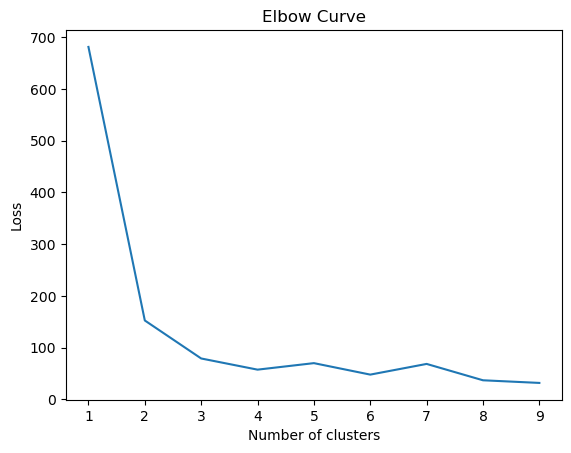

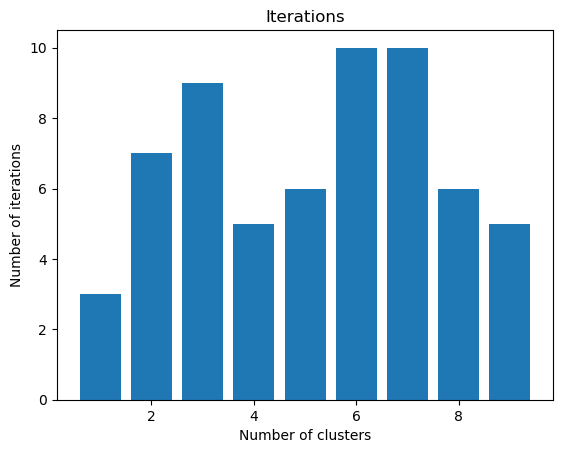

In [3]:
import matplotlib.pyplot as plt

dt = datasets.load_iris().data
algo = NaiveKMeans(dt)

algo.elbow_curve(1, 10)
algo.plot_iterations(1, 10)

algo.k_means(3)
print(algo.cluster_assignation())
print(datasets.load_iris().target)

[1 2 2 1 1 0 0 0 2 0 2 0 2 0 2 1 0 1 1 2 2 1 2 1 0 0 2 0 2 2 1 0 0 0 1 1 1
 2 2 2 2 1 2 0 0 0 2 2 2 2 0 0 1 1 0 1 2 0 1 0 0 2 0 1 2 0 0 0 2 1 2 1 0 1
 1 0 2 1 1 0 1 1 0 0 1 2 0 0 2 0 0 2 0 1 1 2 2 0 2 1 1 2]
[2 1 1 2 2 0 2 0 1 0 1 2 1 0 1 2 0 2 2 1 1 2 1 2 0 2 1 0 1 1 2 0 0 0 2 2 2
 1 1 1 1 2 1 0 0 0 1 1 1 1 0 0 2 2 0 2 1 0 2 0 0 1 2 2 1 0 0 0 1 2 1 2 0 2
 2 0 1 2 2 0 2 2 0 0 2 1 0 0 1 0 0 1 0 2 2 1 1 0 1 0 2 1]
0.9509803921568627


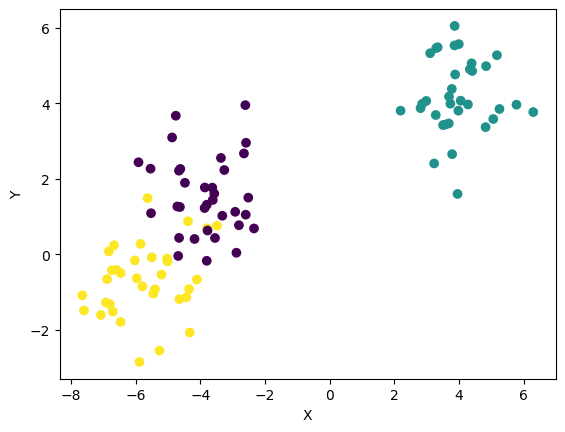

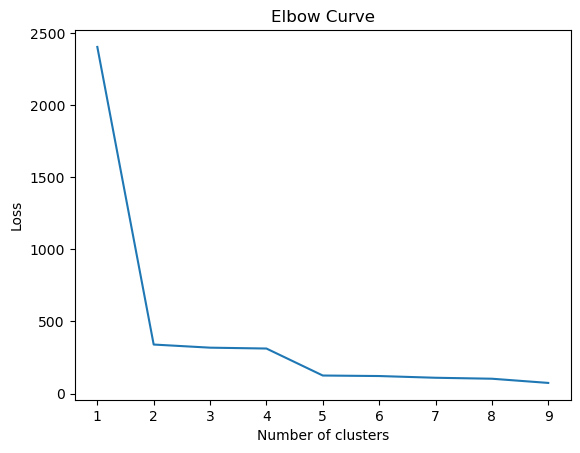

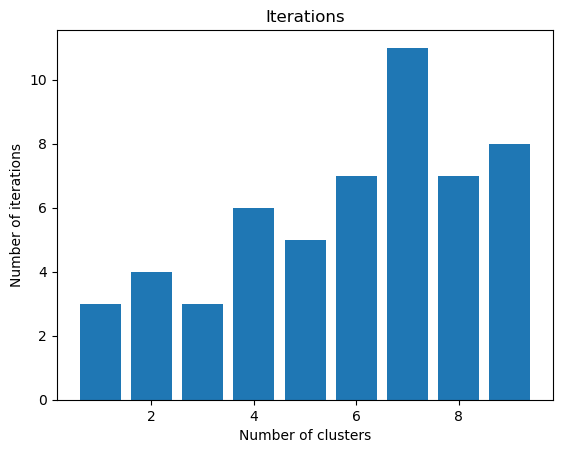

In [5]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=102, centers=3, n_features=2, cluster_std=1)

_, ax = plt.subplots()
scatter = ax.scatter(X[:, 0], X[:, 1], c=y)
ax.set(xlabel="X", ylabel="Y")

algo = NaiveKMeans(X)

algo.elbow_curve(1, 10)
algo.plot_iterations(1, 10)

algo.k_means(3)
print(algo.cluster_assignation())
print(y)
print(algo.verif(y))

In [60]:
# TODO : 
#  - add a method that returns the labels (cluster assignations) for each datapoints
#  - implement an improved version of k-mean using numpy 
#  - implement k-mean with sklearn
#  - implement k-median
#  - time those implementation
#  - HAC


In [23]:
# Let's do HAC
import numpy
from dataclasses import dataclass, field
from sklearn import datasets
import copy


class HAC:
    def __init__(self, data: numpy.ndarray):
        self.X = data
        self.n_rows = self.X.shape[0]

    def single_link(self):
        # First, compute all the distances
        distances = numpy.linalg.norm(self.X[:, numpy.newaxis] - self.X, axis=2)
        # Fill the diag with infinite value
        numpy.fill_diagonal(distances, numpy.inf)

        # Set up our array, assign each datapoint to its own cluster
        arr = numpy.zeros((self.n_rows, self.n_rows))
        for i in range(self.n_rows):
            arr[0, i] = i

        j = 1
        while j < self.n_rows:
            u, v = numpy.unravel_index(distances.argmin(), distances.shape)

            # We remove the distance between u and v from our array of distances
            distances[u, v] = distances[v, u] = numpy.inf

            # Now link data at indices u and v if not already done.
            if arr[j - 1, u] == arr[j - 1, v]:
                continue

            arr[j] = arr[j - 1]
            # Link cluster u and v
            _to_replace = arr[j, v]
            for i in range(self.n_rows):
                if arr[j, i] == _to_replace:
                    arr[j, i] = arr[j, u]
            # TODO: il doit surement y avoir moyen de faire ça avec numpy.where

            j += 1

        return arr

    def complete_link(self):
        # First, compute all the distances
        distances = numpy.linalg.norm(self.X[:, numpy.newaxis] - self.X, axis=2)
        # Fill the diag with infinite value
        numpy.fill_diagonal(distances, numpy.nan)

        # Set up our array, assign each datapoint to its own cluster
        arr = numpy.zeros((self.n_rows, self.n_rows))
        for i in range(self.n_rows):
            arr[0, i] = i

        j = 1
        while j < self.n_rows:
            u, v = numpy.unravel_index(numpy.nanargmin(distances), distances.shape)
            #print(u, v)

            # Now link data at indices u and v if not already done.
            if arr[j - 1, u] == arr[j - 1, v]:
                # We remove the distance between u and v from our array of distances
                distances[u, v] = distances[v, u] = numpy.nan
                continue

            skip = False
            for i in range(self.n_rows):
                if i == u or i == v: continue  # Don't recompare u and v to themselves again.
                if arr[j - 1, i] == arr[j - 1, u]:  # If i is in the same cluster as u
                    #print(f"{j=} {i=} {u=} {distances[i, v]=} {distances[u, v]=}")
                    if distances[i, v] > distances[u, v]:  # And if it's distance to v is greater than d(u,v)
                        skip = True  # then skip the turn
                        break
                # Do the same thing for v
                if arr[j - 1, i] == arr[j - 1, v]:  # If i is in the same cluster as v
                    #print(f"{j=} {i=} {v=} {distances[i, u]=} {distances[u, v]=}")
                    if distances[i, u] > distances[u, v]:  # And if it's distance to u is greater than d(u,v)
                        skip = True  # then skip the turn
                        break

            if skip:
                # We remove the distance between u and v from our array of distances
                distances[u, v] = distances[v, u] = numpy.nan
                continue

            # We remove the distance between u and v from our array of distances
            distances[u, v] = distances[v, u] = numpy.nan

            arr[j] = arr[j - 1]
            # Link cluster u and v
            _to_replace = arr[j, v]
            for i in range(self.n_rows):
                if arr[j, i] == _to_replace:
                    arr[j, i] = arr[j, u]
            # TODO: il doit surement y avoir moyen de faire ça avec numpy.where

            j += 1

        return arr


# TD Clustering et qualité - Figure 1
test1 = numpy.array(
    [[-2.5, -3],  # a'
     [-2.5, -2],  # b'
     [2, -3],  # g
     [2, -2],  # d
     [2, 1],  # e
     [3, 2],  # c
     [3, 3]]  # f
)

# TD Clustering et qualité - Figure 2
test2 = numpy.array(
    [[2, 2],  # a
     [3, 2],  # b
     [0, 3],  # c
     [-4, 3],  # f
     [-2, 2],  # g
     [-2, -1],  # f
     [-2, -5]]  # e
)

# TD K-moyennes - Figure 1
test3 = numpy.array(
    [[2, 6],  # e
     [1, 5.5],  # b
     [1, 5],  # a
     [2.5, 4],  # d
     [4, 4],  # h
     [2, 3],  # c
     [3.5, 2],  # g
     [4, 1]]  # f
)

# Iris data
test4 = datasets.load_iris().data
test4_target = datasets.load_iris().target
"""
truc = numpy.linalg.norm(test[:,numpy.newaxis] - test, axis=2)
numpy.fill_diagonal(truc, numpy.inf)
numpy.unravel_index(numpy.array(
    [[-2, -3],
     [-2, -22],
     [-92, -3]]
).argmin(), test.shape)
truc[0,1] = truc[1,0] = 66
truc[2] = truc[1]
print(truc)
"""
clustering_test1 = HAC(test1)
print("Jeu de test numéro 1:\n"
      "  Single Link")
print(clustering_test1.single_link())
print("\n  Complete Link")
print(clustering_test1.complete_link())

clustering_test2 = HAC(test2)
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~\n\n"
      "Jeu de test numéro 2:\n"
      "  Single Link\n\n"
      " [a  b  c  f  g  d  e ]\n"
      " ----------------------")
print(clustering_test2.single_link())
print("\n  Complete Link\n\n"
      " [a  b  c  f  g  d  e ]\n"
      " -------------------------")
print(clustering_test2.complete_link())

clustering_test3 = HAC(test3)
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~\n\n"
      "Jeu de test numéro 3:\n"
      "  Single Link\n\n"
      " [e  b  a  d  h  c  g  f ]\n"
      " -------------------------")
print(clustering_test3.single_link())
print("\n  Complete Link\n\n"
      " [e  b  a  d  h  c  g  f ]\n"
      " -------------------------")
print(clustering_test3.complete_link())

clustering_test4 = HAC(test4)
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~\n\n"
      "Jeu de test numéro 4:\n"
      "  Single Link")
iris_cluster_assignation_sl = clustering_test4.single_link()[-3]
print(iris_cluster_assignation_sl)
print("\n  Complete Link")
iris_cluster_assignation_cl = clustering_test4.complete_link()[-3]
print(iris_cluster_assignation_cl)

Jeu de test numéro 1:
  Single Link
[[0. 1. 2. 3. 4. 5. 6.]
 [0. 0. 2. 3. 4. 5. 6.]
 [0. 0. 2. 2. 4. 5. 6.]
 [0. 0. 2. 2. 4. 5. 5.]
 [0. 0. 2. 2. 4. 4. 4.]
 [0. 0. 2. 2. 2. 2. 2.]
 [0. 0. 0. 0. 0. 0. 0.]]

  Complete Link
[[0. 1. 2. 3. 4. 5. 6.]
 [0. 0. 2. 3. 4. 5. 6.]
 [0. 0. 2. 2. 4. 5. 6.]
 [0. 0. 2. 2. 4. 5. 5.]
 [0. 0. 2. 2. 4. 4. 4.]
 [0. 0. 0. 0. 4. 4. 4.]
 [0. 0. 0. 0. 0. 0. 0.]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~

Jeu de test numéro 2:
  Single Link

 [a  b  c  f  g  d  e ]
 ----------------------
[[0. 1. 2. 3. 4. 5. 6.]
 [0. 0. 2. 3. 4. 5. 6.]
 [0. 0. 0. 3. 4. 5. 6.]
 [0. 0. 0. 3. 0. 5. 6.]
 [3. 3. 3. 3. 3. 5. 6.]
 [3. 3. 3. 3. 3. 3. 6.]
 [3. 3. 3. 3. 3. 3. 3.]]

  Complete Link

 [a  b  c  f  g  d  e ]
 -------------------------
[[0. 1. 2. 3. 4. 5. 6.]
 [0. 0. 2. 3. 4. 5. 6.]
 [0. 0. 2. 3. 2. 5. 6.]
 [0. 0. 2. 2. 2. 5. 6.]
 [0. 0. 2. 2. 2. 5. 5.]
 [0. 0. 0. 0. 0. 5. 5.]
 [0. 0. 0. 0. 0. 0. 0.]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~

Jeu de test numéro 3:
  Single Link

 [e  b  a  d  h  c  

In [32]:
def purity(cluster_assignation, target):
    """
    It is assumed that both arrays are:
        - 1-dimensional arrays
        - are of the same length
        - represent data in the same order.
    This function computes the total number of correctly assigned clusters.
    :param cluster_assignation: 
    :param target: 
    :return: 
    """
    # First, as the cluster names could be anything, we need to normalize them
    uni = {val: i for i, val in enumerate(numpy.unique(cluster_assignation))}

    # Then rewrite the cluster assignations with proper values 
    cluster_assignation = [uni[val] for val in cluster_assignation]

    # Create a table of the possible mapping
    possible_mappings = [[0] * len(target) for _ in range(len(cluster_assignation))]
    for el_a, el_b in zip(cluster_assignation, target):
        possible_mappings[el_a][el_b] += 1

    # Now, by taking the maximum value in each row, retrieve the actual mapping.
    mapping = numpy.argmax(possible_mappings, axis=1)

    # Return the number of correct assignations
    return sum(mapping[predicted] == target[i] for i, predicted in enumerate(cluster_assignation))


iris_single_link = purity(iris_cluster_assignation_sl, test4_target)
iris_complete_link = purity(iris_cluster_assignation_cl, test4_target)
print(f"Pour les résultats de HAC sur le dataset iris en s'arrêtant à 3 cluster:\n"
      f"  Single Link:\n"
      f"    -> {iris_single_link} bonnes affectations sur 150, soit {100 * iris_single_link / 150:.1f}% de bonnes assignations\n"
      f"  Complete Link:\n"
      f"    -> {iris_complete_link} bonnes affectations sur 150, soit {100 * iris_complete_link / 150:.1f}% de bonnes assignations")
print()

Pour les résultats de HAC sur le dataset iris en s'arrêtant à 3 cluster:
  Single Link:
    -> 102 bonnes affectations sur 150, soit 68.0% de bonnes assignations
  Complete Link:
    -> 138 bonnes affectations sur 150, soit 92.0% de bonnes assignations



In [170]:
from collections import defaultdict


def centroid(cluster: numpy.ndarray, method: str = 'mean') -> numpy.ndarray:
    match method:
        case 'mean':
            return numpy.mean(cluster, axis=0)
        case 'median':
            return numpy.median(cluster, axis=0)
        case _:
            raise ValueError


def distances(cluster: numpy.ndarray) -> numpy.ndarray:
    # Compute the distances between each points
    vectorized_function = numpy.vectorize(
        lambda x, y: numpy.linalg.norm(x - y),  # Computes the distance between x and y
        signature='(n),(n)->()'
        # tells NumPy that the function takes two 1D arrays (rows of length n) and returns a scalar value (()).
    )

    # Apply the function to the rows of the two arrays
    output_array = vectorized_function(
        cluster[:, numpy.newaxis, :],
        # reshapes the array to have an extra axis, making it of shape (N, 1, M). This allows broadcasting to work with the second array of shape (P, M).
        cluster
    )

    # Because the array is symmetrical, we only need to keep the upper triangle (excluding the diagonal)
    return output_array[numpy.triu_indices_from(output_array, k=1)]


def diameter(cluster: numpy.ndarray, method: str = 'largest') -> float:
    match method:
        case 'bounding_box':
            return numpy.linalg.norm(cluster.max(axis=0) - cluster.min(axis=0))
        case 'centroid_mean':
            c = centroid(cluster, 'mean')
            distances_to_center = numpy.linalg.norm(cluster - c, axis=1)
            return distances_to_center.max()
        case 'centroid_median':
            c = centroid(cluster, 'median')
            distances_to_center = numpy.linalg.norm(cluster - c, axis=1)
            return distances_to_center.max()
        case 'bounding_sphere':
            # TODO: implement this based on Ritter's bouding sphere algorithm
            # https://en.wikipedia.org/wiki/Bounding_sphere#Ritter's_bounding_sphere
            raise NotImplementedError
        case 'largest':
            return numpy.max(distances(cluster))
        case 'average':
            return numpy.mean(distances(cluster))
        case 'median':
            return numpy.median(distances(cluster))


def dunn_index(datapoints, cluster_assignation):
    """
    It is assumed that both arrays are:
        - 1-dimensional arrays
        - are of the same length
        - represent data in the same order.
        
    :param datapoints: 
    :param cluster_assignation: 
    :return: 
    """
    clusters = defaultdict(list)
    for cluster, data in zip(cluster_assignation, datapoints):
        clusters[cluster].append(data)
    clusters = dict(map(lambda x: (x[0], numpy.array(x[1])), clusters.items()))

    clusters_centroid = numpy.array([centroid(cluster) for cluster in clusters.values()])
    clusters_diameter = numpy.fromiter((diameter(cluster, 'centroid_mean') for cluster in clusters.values()), float)
    
    print(distances(clusters_centroid).min(), clusters_diameter.max())
    return distances(clusters_centroid).min() / clusters_diameter.max()


# TD Clustering et qualité - Figure 1
test1bis = numpy.array(
    [[-2, -3],  # a'
     [-2, -2],  # b'
     [2, -3],  # g
     [2, -2],  # d
     [2, 1],  # e
     [3, 2],  # c
     [3, 3]]  # f
)
print(HAC(test1bis).complete_link()[-4])
dunn_index(test1bis, HAC(test1bis).complete_link()[-4])

[0. 0. 2. 2. 4. 5. 5.]
1.8027756377319946 0.5


3.605551275463989

In [133]:
numpy.fromiter((x + 1 for x in range(3)), int)


array([1, 2, 3])